# Down syndrome in mice

Expression levels of 77 proteins measured in the cerebral cortex of 8 classes of control and Down syndrome mice exposed to context fear conditioning, a task used to assess associative learning.

The data set consists of the expression levels of 77 proteins/protein modifications that produced detectable signals in the nuclear fraction of cortex.   
The eight classes of mice are described based on features such as genotype, behavior and treatment.  
According to genotype, mice can be control or trisomic. According to behavior, some mice have been stimulated to learn (context-shock) and others have not (shock-context) and in order to assess the effect of the drug memantine in recovering the ability to learn in trisomic mice, some mice have been injected with the drug and others have not.

Classes:  
c-CS-s: control mice, stimulated to learn, injected with saline (9 mice)  
c-CS-m: control mice, stimulated to learn, injected with memantine (10 mice)  
c-SC-s: control mice, not stimulated to learn, injected with saline (9 mice)  
c-SC-m: control mice, not stimulated to learn, injected with memantine (10 mice)  
t-CS-s: trisomy mice, stimulated to learn, injected with saline (7 mice)  
t-CS-m: trisomy mice, stimulated to learn, injected with memantine (9 mice)  
t-SC-s: trisomy mice, not stimulated to learn, injected with saline (9 mice)  
t-SC-m: trisomy mice, not stimulated to learn, injected with memantine (9 mice)  

##### The aim is to identify subsets of proteins that are discriminant between the classes.

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score
import optuna
from imblearn.over_sampling import RandomOverSampler

In [80]:
data = pd.read_csv("Data_Cortex_Nuclear.csv")

In [81]:
data.shape

(1080, 82)

In [82]:
protein = ['DYRK1A_N', 'ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pAKT_N','pBRAF_N', 'pCAMKII_N', 'pCREB_N', 'pELK_N', 'pERK_N', 'pJNK_N',
       'PKCA_N', 'pMEK_N', 'pNR1_N', 'pNR2A_N', 'pNR2B_N', 'pPKCAB_N', 'pRSK_N', 'AKT_N', 'BRAF_N', 'CAMKII_N', 'CREB_N', 'ELK_N', 'ERK_N',
       'GSK3B_N', 'JNK_N', 'MEK_N', 'TRKA_N', 'RSK_N', 'APP_N', 'Bcatenin_N', 'SOD1_N', 'MTOR_N', 'P38_N', 'pMTOR_N', 'DSCR1_N', 'AMPKA_N', 'NR2B_N',
       'pNUMB_N', 'RAPTOR_N', 'TIAM1_N', 'pP70S6_N', 'NUMB_N', 'P70S6_N', 'pGSK3B_N', 'pPKCG_N', 'CDK5_N', 'S6_N', 'ADARB1_N', 'AcetylH3K9_N',
       'RRP1_N', 'BAX_N', 'ARC_N', 'ERBB4_N', 'nNOS_N', 'Tau_N', 'GFAP_N', 'GluR3_N', 'GluR4_N', 'IL1B_N', 'P3525_N', 'pCASP9_N', 'PSD95_N',
       'SNCA_N', 'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'SHH_N', 'BAD_N', 'BCL2_N', 'pS6_N', 'pCFOS_N', 'SYP_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N', 'CaNA_N']

In [83]:
endpoint = ['Genotype', 'Treatment', 'Behavior', 'class']

In [84]:
label_encoder = LabelEncoder()
for column in endpoint:
    data[column] = label_encoder.fit_transform(data[column])

### Classes of mice

In [85]:
protein.append("class")

In [86]:
protein__data = data[protein]

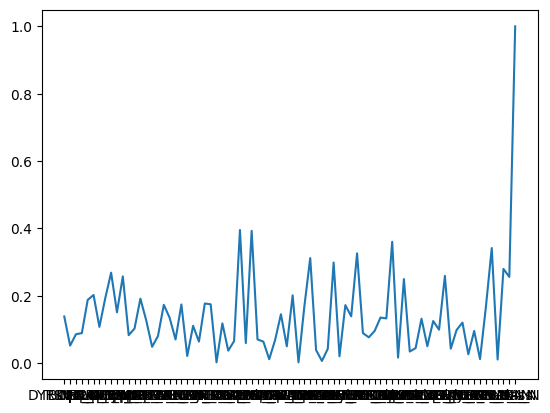

In [87]:
plt.plot(abs(protein__data.corr()["class"]))

In [88]:
x = pd.DataFrame(abs(protein__data.corr()["class"]))
protein__data2 = protein__data[x[x["class"]>0.25].index.tolist()] #Removing low correlated proteins 

In [89]:
protein__data2.columns

Index(['pCREB_N', 'pERK_N', 'APP_N', 'SOD1_N', 'pP70S6_N', 'pPKCG_N',
       'AcetylH3K9_N', 'Tau_N', 'Ubiquitin_N', 'H3AcK18_N', 'H3MeK4_N',
       'CaNA_N', 'class'],
      dtype='object')

In [90]:
col = ['pCREB_N', 'pERK_N', 'APP_N', 'SOD1_N', 'pP70S6_N', 'pPKCG_N',
       'AcetylH3K9_N', 'Tau_N', 'Ubiquitin_N', 'H3AcK18_N', 'H3MeK4_N',
       'CaNA_N']

In [91]:
protein__data2 = protein__data2.dropna()

### scaling

In [92]:
scaler = MinMaxScaler() 
data2 = pd.DataFrame(scaler.fit_transform(protein__data2.drop('class', axis=1)),columns=col)

In [44]:
X = data2
y = protein__data2['class']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)
xgb = XGBClassifier(n_estimators=100,enable_categorical=True)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:",recall_score(y_test, preds, average='micro'))
print("F1-Score:", f1_score(y_test, preds, average='micro'))
print(confusion_matrix(y_test, preds))

XGBoost's prediction accuracy is: 97.27
Precision: 0.9727272727272728
Recall: 0.9727272727272728
F1-Score: 0.9727272727272728
[[25  1  0  0  0  0  0  0]
 [ 0 26  0  0  1  1  0  0]
 [ 0  0 19  0  0  0  0  0]
 [ 0  0  1 25  0  0  0  0]
 [ 0  1  0  0 32  0  0  0]
 [ 0  0  0  0  0 33  0  0]
 [ 0  0  1  0  0  0 17  0]
 [ 0  0  0  0  0  0  0 37]]


<BarContainer object of 12 artists>

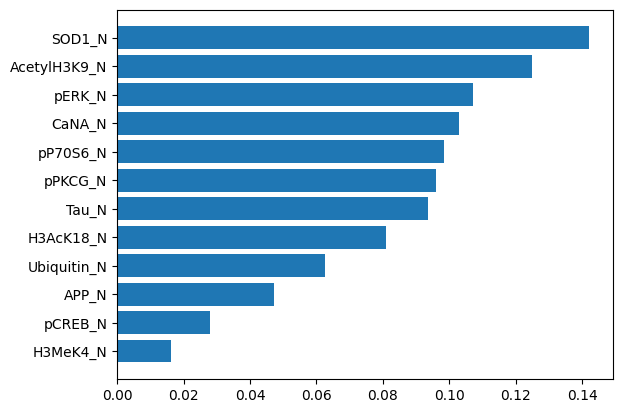

In [59]:
idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[idx],xgb.feature_importances_[idx])

Model performs good prediction amonge the 8 classes with a prediction accuracy of 97.27. SOD1 and AcetylH3K9 are top 2 proteins contributing to the model accuracy.  
Hence a sub set of proteins namely pCREB, pERK, APP, SOD1, pP70S6, pPKCG, AcetylH3K9, Tau, Ubiquitin, H3AcK18, H3MeK4 and CaNA are enough to discriminant between the classes

### PCA

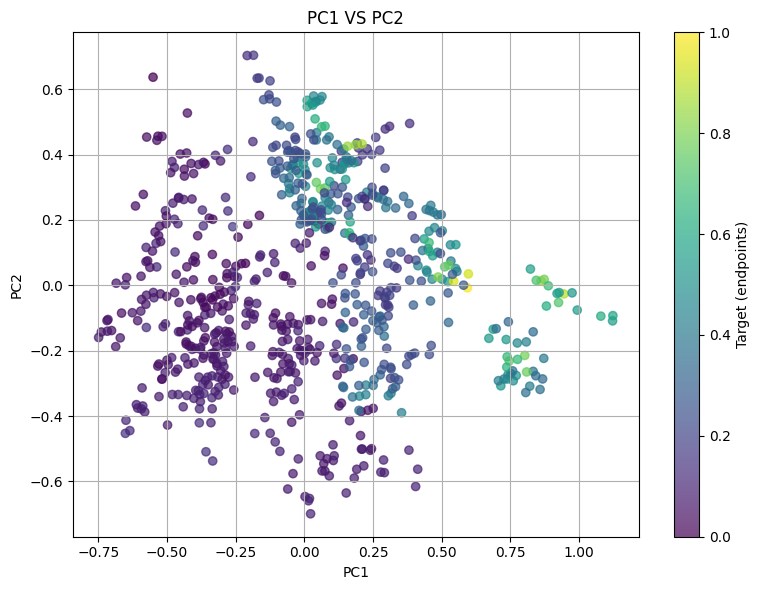

In [63]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data2)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Target'] = data2['SOD1_N']

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df['Target'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Target (endpoints)')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 VS PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

### Behavior of mice -> c/s or s/c
According to behavior, some mice have been stimulated to learn (c/s) and others have not (s/c)

In [64]:
data["Behavior"].value_counts()

1    555
0    525
Name: Behavior, dtype: int64

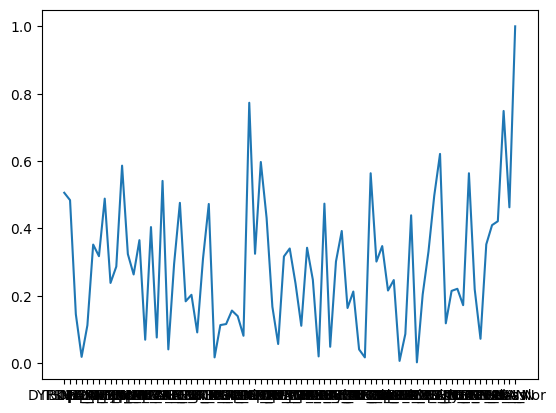

In [65]:
protein.append("Behavior")
protein__data = data[protein]
plt.plot(abs(protein__data.corr()["Behavior"]))

In [66]:
x = pd.DataFrame(abs(protein__data.corr()["Behavior"]))
protein__data2 = protein__data[x[x["Behavior"]>0.25].index.tolist()] #Removing low correlated proteins 

In [67]:
protein__data2.columns

Index(['DYRK1A_N', 'ITSN1_N', 'pAKT_N', 'pBRAF_N', 'pCAMKII_N', 'pELK_N',
       'pERK_N', 'pJNK_N', 'PKCA_N', 'pMEK_N', 'pNR2A_N', 'pPKCAB_N', 'AKT_N',
       'BRAF_N', 'ERK_N', 'GSK3B_N', 'SOD1_N', 'MTOR_N', 'P38_N', 'pMTOR_N',
       'NR2B_N', 'pNUMB_N', 'pP70S6_N', 'pGSK3B_N', 'CDK5_N', 'S6_N', 'ARC_N',
       'ERBB4_N', 'nNOS_N', 'IL1B_N', 'PSD95_N', 'SNCA_N', 'Ubiquitin_N',
       'pS6_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N', 'CaNA_N', 'class',
       'Behavior'],
      dtype='object')

In [68]:
col =['DYRK1A_N', 'ITSN1_N', 'pAKT_N', 'pBRAF_N', 'pCAMKII_N', 'pELK_N',
       'pERK_N', 'pJNK_N', 'PKCA_N', 'pMEK_N', 'pNR2A_N', 'pPKCAB_N', 'AKT_N',
       'BRAF_N', 'ERK_N', 'GSK3B_N', 'SOD1_N', 'MTOR_N', 'P38_N', 'pMTOR_N',
       'NR2B_N', 'pNUMB_N', 'pP70S6_N', 'pGSK3B_N', 'CDK5_N', 'S6_N', 'ARC_N',
       'ERBB4_N', 'nNOS_N', 'IL1B_N', 'PSD95_N', 'SNCA_N', 'Ubiquitin_N',
       'pS6_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N', 'CaNA_N']

In [69]:
protein__data2 = protein__data2.dropna()

### scaling

In [83]:
scaler = MinMaxScaler()
data2 = pd.DataFrame(scaler.fit_transform(protein__data2.drop('Behavior', axis=1)),columns=col)

In [91]:
X = data2
y = protein__data2['Behavior']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)
xgb = XGBClassifier(n_estimators=100,enable_categorical=True)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:",recall_score(y_test, preds, average='micro'))
print("F1-Score:", f1_score(y_test, preds, average='micro'))
print(confusion_matrix(y_test, preds))

XGBoost's prediction accuracy is: 100.00
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
[[ 91   0]
 [  0 111]]


<BarContainer object of 8 artists>

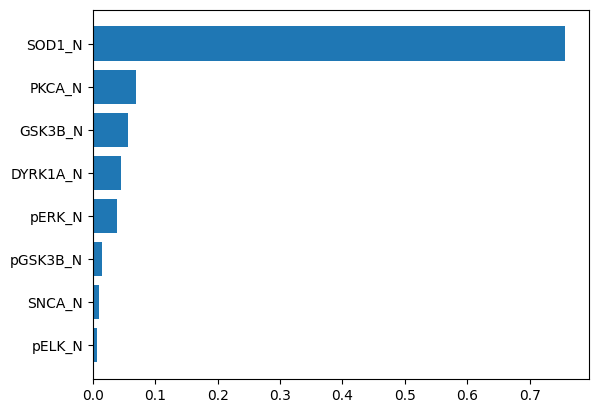

In [98]:
idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[idx][30:38],xgb.feature_importances_[idx][30:38])

Model performs good prediction amonge the 2 classes behavior with a prediction accuracy of 1. SOD1 contributes more then any other protein for the model accuracy.  
Hence the level of SOC1 can be a deciding factor for brain activity resulted by the stimulated learning given to the mice

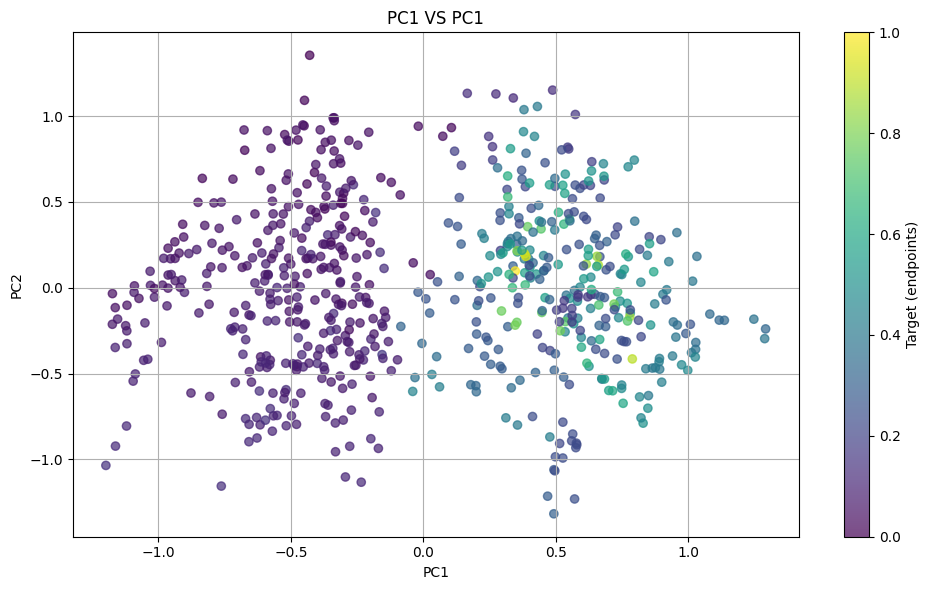

In [101]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data2)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Target'] = data2['SOD1_N']

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df['Target'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Target (endpoints)')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 VS PC1")
plt.grid(True)
plt.tight_layout()
plt.show()

### Genotype of mice -> Control or Ts65Dn

In [102]:
data["Genotype"].value_counts()

0    570
1    510
Name: Genotype, dtype: int64

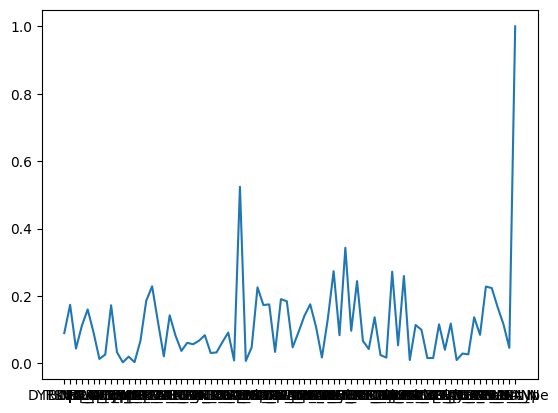

In [110]:
protein.append("Genotype")
protein__data = data[protein]
plt.plot(abs(protein__data.corr()["Genotype"]))

In [134]:
x = pd.DataFrame(abs(protein__data.corr()["Genotype"]))
protein__data2 = protein__data[x[x["Genotype"]>0.20].index.tolist()]
protein__data2.columns

Index(['pNR2A_N', 'APP_N', 'MTOR_N', 'pPKCG_N', 'S6_N', 'AcetylH3K9_N',
       'Tau_N', 'GluR3_N', 'SYP_N', 'H3AcK18_N', 'Genotype'],
      dtype='object')

In [138]:
col = ['pNR2A_N', 'APP_N', 'MTOR_N', 'pPKCG_N', 'S6_N', 'AcetylH3K9_N',
       'Tau_N', 'GluR3_N', 'SYP_N', 'H3AcK18_N']
protein__data2 = protein__data2.dropna()

scaler = MinMaxScaler() #scaling
data2 = pd.DataFrame(scaler.fit_transform(protein__data2.drop('Genotype', axis=1)),columns=col)

In [139]:
X = data2
y = protein__data2['Genotype']

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
xgb = XGBClassifier(n_estimators=100,enable_categorical=True)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:",recall_score(y_test, preds, average='micro'))
print("F1-Score:", f1_score(y_test, preds, average='micro'))
print(confusion_matrix(y_test, preds))

XGBoost's prediction accuracy is: 97.78
Precision: 0.9777777777777777
Recall: 0.9777777777777777
F1-Score: 0.9777777777777777
[[141   3]
 [  3 123]]


<BarContainer object of 10 artists>

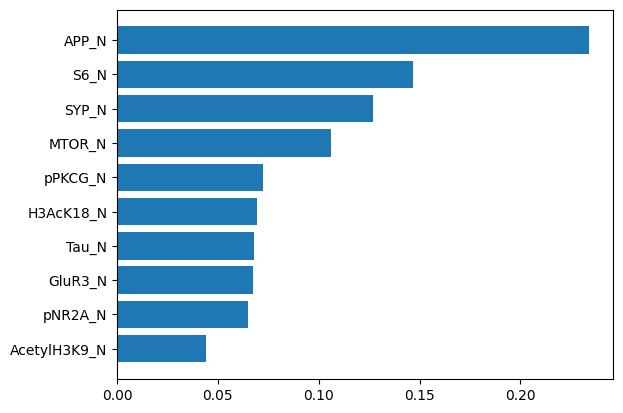

In [154]:
idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[idx],xgb.feature_importances_[idx])

The subset of protein namely pNR2A, APP, MTOR, pPKCG, S6, AcetylH3K9, Tau, GluR3, SYP and H3AcK18 can be markers genes for differentiating between normal and Ts65Dn mice

### Treatment on mice -> Memantine or Saline

In [164]:
data["Treatment"].value_counts()

0    570
1    510
Name: Treatment, dtype: int64

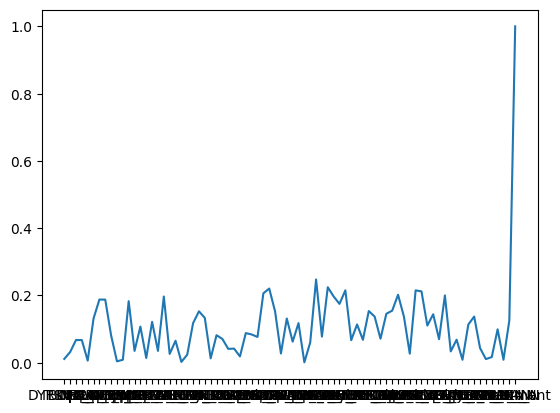

In [165]:
protein.append("Treatment")
protein__data = data[protein]
plt.plot(abs(protein__data.corr()["Treatment"]))

In [189]:
x = pd.DataFrame(abs(protein__data.corr()["Treatment"]))
protein__data2 = protein__data[x[x["Treatment"]>0.15].index.tolist()]
protein__data2.columns

Index(['pBRAF_N', 'pCAMKII_N', 'pJNK_N', 'pPKCAB_N', 'ELK_N', 'P38_N',
       'pMTOR_N', 'DSCR1_N', 'NUMB_N', 'pGSK3B_N', 'pPKCG_N', 'CDK5_N', 'S6_N',
       'BAX_N', 'Tau_N', 'GFAP_N', 'IL1B_N', 'P3525_N', 'Ubiquitin_N',
       'Treatment'],
      dtype='object')

In [190]:
col = ['pBRAF_N', 'pCAMKII_N', 'pJNK_N', 'pPKCAB_N', 'ELK_N', 'P38_N',
       'pMTOR_N', 'DSCR1_N', 'NUMB_N', 'pGSK3B_N', 'pPKCG_N', 'CDK5_N', 'S6_N',
       'BAX_N', 'Tau_N', 'GFAP_N', 'IL1B_N', 'P3525_N', 'Ubiquitin_N']

In [191]:
protein__data2 = protein__data2.dropna()
scaler = MinMaxScaler() #scaling
data2 = pd.DataFrame(scaler.fit_transform(protein__data2.drop('Treatment', axis=1)),columns=col)

In [192]:
X = data2
y = protein__data2['Treatment']

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
xgb = XGBClassifier(n_estimators=100,enable_categorical=True)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:",recall_score(y_test, preds, average='micro'))
print("F1-Score:", f1_score(y_test, preds, average='micro'))
print(confusion_matrix(y_test, preds))

XGBoost's prediction accuracy is: 98.12
Precision: 0.9811912225705329
Recall: 0.9811912225705329
F1-Score: 0.9811912225705329
[[162   4]
 [  2 151]]


<BarContainer object of 19 artists>

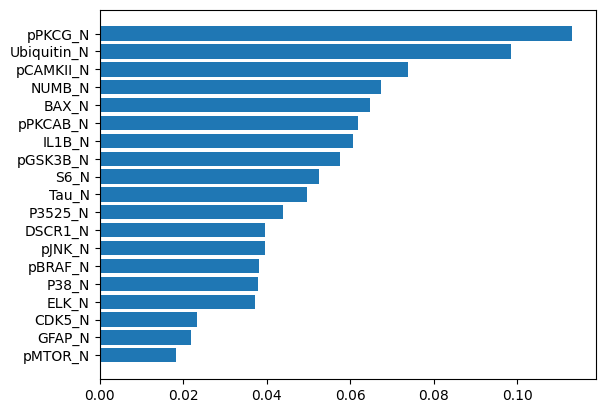

In [207]:
idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[idx],xgb.feature_importances_[idx])

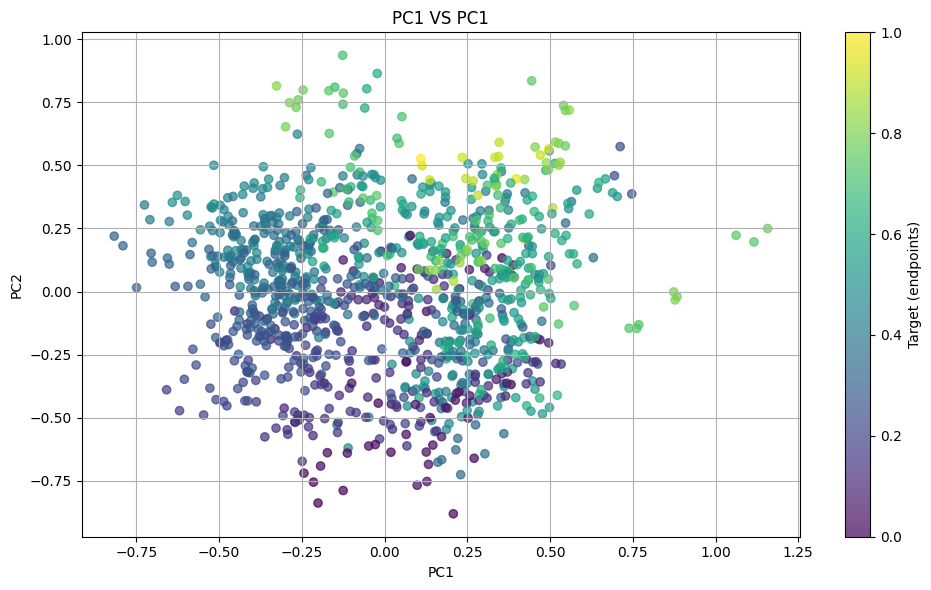

In [208]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data2)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Target'] = data2['pPKCG_N']

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df['Target'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Target (endpoints)')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 VS PC1")
plt.grid(True)
plt.tight_layout()
plt.show()